# Lesson 1 - What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you [here](http://course-v3.fast.ai/notebook_tutorial.html). 

In this lesson we will build our first image classifier from scratch, and achieve world-class results. Let's dive in!

Our first step is to import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by O. M. Parkhi et al., 2012 which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories.

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [7]:
??untar_data

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

In [2]:
path = untar_data(URLs.PETS); path

PosixPath('/data1/jhoward/git/fastai/fastai/../data/oxford-iiit-pet')

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/2/library/re.html).

In [8]:
??ImageDataBunch.from_name_re

In [3]:
path.ls()

['annotations', 'images']

In [4]:
path_anno = path/'annotations'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/data1/jhoward/git/fastai/fastai/../data/oxford-iiit-pet/images/scottish_terrier_65.jpg'),
 PosixPath('/data1/jhoward/git/fastai/fastai/../data/oxford-iiit-pet/images/British_Shorthair_109.jpg'),
 PosixPath('/data1/jhoward/git/fastai/fastai/../data/oxford-iiit-pet/images/Egyptian_Mau_104.jpg'),
 PosixPath('/data1/jhoward/git/fastai/fastai/../data/oxford-iiit-pet/images/samoyed_190.jpg'),
 PosixPath('/data1/jhoward/git/fastai/fastai/../data/oxford-iiit-pet/images/British_Shorthair_110.jpg')]

In [6]:
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

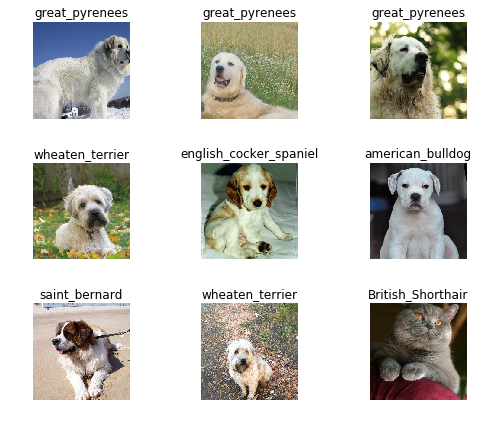

In [7]:
data.show_batch(rows=3, figsize=(7,6))

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a linear layer head as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the next lesson. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 ouptuts).

We will train for 5 epochs (5 cycles through all our data).

In [13]:
??create_head

In [8]:
learn = ConvLearner(data, tvm.resnet34, metrics=accuracy)

In [8]:
learn.fit_one_cycle(5)

Total time: 01:22
epoch  train loss  valid loss  accuracy
0      1.260069    0.331716    0.909774  (00:17)
1      0.533219    0.257838    0.917977  (00:16)
2      0.362374    0.233951    0.926863  (00:16)
3      0.245795    0.203109    0.937115  (00:16)
4      0.203346    0.204246    0.939166  (00:16)



In [9]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
??ClassificationInterpretation

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Egyptian_Mau', 'Bengal', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4)]

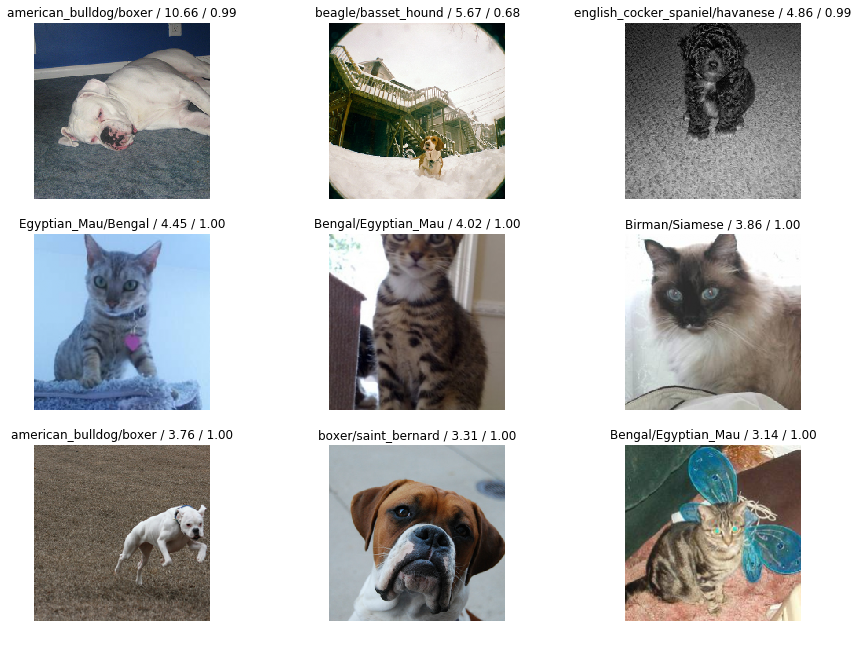

In [42]:
interp.plot_top_losses(9, figsize=(15,11))

In [34]:
doc(interp.plot_top_losses)

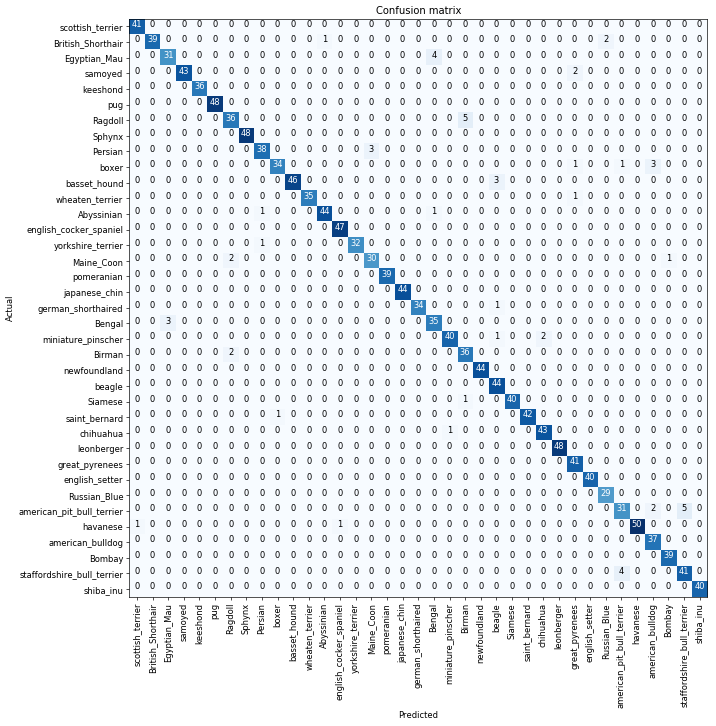

In [40]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Since our model is working as we expect it to, we will load the weights (this means that we will set our neural network's parameters after our last training) and we will train some more.

Now our accuracy increased by 3 points to 97% (97% of our examples were classified correctly!) and only 2 confusions happened more than 3 times (half as many as before). We are making good progress!

In [10]:
learn.load('stage-1')

In [11]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

Total time: 00:22
epoch  train loss  valid loss  accuracy
0      0.206441    0.091423    0.970511  (00:22)



In [12]:
learn.save('stage-2')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=3)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('Ragdoll', 'Birman', 4)]

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers, for more details see paper [here](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=288)
data.normalize(imagenet_stats)

In [11]:
learn = ConvLearner(data, tvm.resnet50, metrics=accuracy)

In [44]:
learn.fit_one_cycle(5)

Total time: 03:51
epoch  train loss  valid loss  accuracy
0      0.747422    0.227084    0.927371  (00:53)
1      0.367308    0.188554    0.936113  (00:44)
2      0.237050    0.186666    0.943510  (00:44)
3      0.153789    0.157036    0.949563  (00:44)
4      0.105048    0.145655    0.950235  (00:44)



In [45]:
learn.save('stage-1-50')

In [12]:
learn.load('stage-1-50')

Yes, we achieved a 0.5% increase in accuracy and 1.7 decrease in loss! This is a very good improvement considering our accuracy was already over 97%. But there is one more trick we can use to push our results a little bit more.

In [13]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr=slice(1e-6,1e-4))

Total time: 01:12
epoch  train loss  valid loss  accuracy
0      0.124407    0.074122    0.975920  (01:12)



We are going to implement test-time augmentation: we are not going to show the model the image to get its prediction but we are first going to augment the image (by cropping, zooming and flipping), then take the prediction of each of the augmented images and the average of these predictions will be our final prediction.

This enables us to gain an extra 0.2% accuracy!

In [14]:
accuracy(*learn.TTA())

Total time: 01:05



tensor(0.9779)